## Balance controlled plasticity: Figures 2 & 3 notebook

This is a standalone notebook.
It uses the E/I assembly models defined within the `bcp` package.

Simulations reported in Figures 2 & 3 of the main paper are run within this notebook.

In [263]:
import numpy as np
from pathlib import Path

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# prevent jax from using jax-metal GPU
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
import numpy as np

from functools import partial
from jax import jit, vmap

# PLOTTING
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('spiffy') # spiffy style (optional)

from spiffyplots import MultiPanel
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",})
from cmcrameri import cm as cmc

import diffrax
from diffrax import (
    diffeqsolve,
    ODETerm,
    LinearInterpolation,
    SaveAt,
    ConstantStepSize,
)

from bcp.core.activation import ReLU
from bcp.core.controller import LeakyPIController
from bcp.core.losses import MSE
from bcp.onlinelearning import ExcInhAssemblyOnlineLearningVF
from bcp.utils.patternstimuli import PatternStimuli

from bcp.utils.plotting import add_scalebar


#### Directory setup

In [264]:
figure_directory = Path("figures")

# Create the directory if it doesn't exist
if not figure_directory.exists():
    figure_directory.mkdir(parents=True)

#### Plotting parameters

In [265]:
cm = 1 / 2.54  # centimeters in inches

singlecolwidth = 8.5 * cm
onehalfcolwidth = 11.4 * cm
doublecolwidth = 17.4 * cm

color_exc = '#CD2027'
color_inh = '#0077B8'
color_inh_ff = '#57CAF1'
color_inputs = '#808285'
color_openloop = 'gray'
color_closedloop = '#F49F1E'
color_target = 'black'
color_accent = 'black'
color_shading = 'gray'

linewidth = 1.0

colors_patterns = ['#5f8d66', '#88ae78', '#adcc99']


#### Simulation parameters

In [266]:
# RNG
# # # # # # # #
seed = 2025
rng = jax.random.PRNGKey(seed)


# Simulation
# # # # # # # #
dt = 1e-3
rec_dt = dt
T_chunk = 15     # [s]
timesteps_chunk = int(T_chunk / dt)
ts_chunk = np.arange(0, T_chunk, dt)
rec_ts_chunk = np.arange(0, T_chunk, rec_dt)

# Input parameters
# # # # # # # #
input_dt = 1e-3
timesteps_input_chunk = int(T_chunk / input_dt)
inp_ts_chunk = np.arange(0, T_chunk, input_dt)
Nb_patterns = 3
Nb_inputs = 10
inputOU_tau = 0.5    # [s]
inputOU_sigma = 1.0
inputOU_mu = 0.0
inputOU_thresh = 0.5
inputFilterTau = 500e-3
loading_type='normal'

# Network parameters
# # # # # # # #
dim_input = Nb_inputs
inp_fanout = 10
nb_ensembles = 1
dim_output = 1
nb_exc = 16
nb_inh = 4
nb_exc_per_ensemble = nb_exc // nb_ensembles
nb_inh_per_ensemble = nb_inh // nb_ensembles

tauE = 30e-3
tauI = 20e-3
tauOut = 30e-3
tauSlow = 20
tauPre = 30e-3

alpha = 0.5

actE = ReLU()
actI = ReLU()

# Random proportion in membership matrix
perc_random = 0

# Controller
loss = MSE()
k_p = 1.0
k_i = 0.0
tau_c = tauOut
controller = LeakyPIController(loss=loss, dim_output=dim_output, k_p=k_p, k_i=k_i, leak=1.0, tau=tau_c)

# Learning rate
eta_OUT = 0.0
eta_FF = 0.05

# Solver
#solver = diffrax.Tsit5()
step_size = diffrax.PIDController(
    rtol=1e-3,
    atol=1e-6,
    pcoeff=0.1,
    icoeff=0.3,
    dcoeff=0.1,
    dtmin=dt / 10,
    dtmax=100 * dt,
    factormin=0.1,
    factormax=2,
)

solver = diffrax.Tsit5()
step_size = ConstantStepSize()

#### Initialize inputs, model and state

In [267]:
# RNG
key_input, key_vf, rng = jax.random.split(rng, 3)

inputs = PatternStimuli(input_dt, Nb_patterns,
                        inputOU_tau, inputOU_sigma, inputOU_mu, True, inputOU_thresh,
                        inputFilterTau, True, Nb_inputs=Nb_inputs, linear_combination=True,
                        rng_key=key_input)

vf = ExcInhAssemblyOnlineLearningVF(dim_input, nb_ensembles, nb_exc, nb_inh, dim_output, 
                    actE, actI, tauE, tauI, tauOut, tauSlow, tauPre, eta_OUT, eta_FF, alpha, 
                    rng_key=key_vf, perc_overlap=0, binary_membership=False,
                    controller=controller, normalize_membership=True)

state = vf.get_initial_state()

# Hardcode readout weights
state['W_OUT'] = jnp.array([[1.0]])

state['W_FF'] = state['W_FF'] + 0.1  #BIAS TOWARDS POSITIVE RECEPTIVE FIELD

In [268]:
print(key_input, key_vf, rng)

[3062749294 2783230690] [2811127096 2388153550] [1350200295 2723403145]


In [269]:
print(state['W_FF'])

[[ 0.09746081]
 [-0.03213023]
 [ 0.24460432]
 [ 0.3046428 ]
 [ 0.56006193]
 [ 0.3911059 ]
 [ 0.30279967]
 [ 0.21606714]
 [ 0.20217943]
 [-0.369045  ]]


#### Functions for simulation

In [270]:
def get_x_and_y(inputs, y_idx, seed=None):
    p, x = inputs.simulate(timesteps_input_chunk, seed)
    y = p[:, y_idx].reshape(-1, 1)
    
    # Add small selectivity to other patterns
    y = y + 0.1 * p[:, np.arange(p.shape[1]) != y_idx].sum(axis=1).reshape(-1, 1)
    return x, y

def get_p_and_x(inputs, seed=None):
    p, x = inputs.simulate(timesteps_input_chunk, seed)
    return p, x

def interpolate(x, y):
    x_interp = LinearInterpolation(inp_ts_chunk, x)
    y_interp = LinearInterpolation(inp_ts_chunk, y)
    return x_interp, y_interp

class SimulationRunner:
    
    def __init__(self, 
                 vectorfield, 
                 solver, 
                 stepsize_controller,
                 dt: float,
                 rec_dt: float,
                 T: float) -> None:

        self.vectorfield = vectorfield
        self.solver = solver
        self.stepsize_controller = stepsize_controller
        self.dt = dt
        self.T = T
        self.rec_ts = jnp.arange(0, T, rec_dt)

    @partial(jit, static_argnums=(0,))
    def __call__(self, state, inputs):
        
        def f(t, state, etc):
            return self.vectorfield(state, t, inputs)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            self.solver,
            y0=state,
            t0=0,
            t1=self.T,
            dt0=self.dt,
            saveat=SaveAt(ts=self.rec_ts),
            stepsize_controller=self.stepsize_controller,
            max_steps=None
        )
        
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state, sol
    
    @partial(jit, static_argnums=(0,))
    def closedloop_with_fixed_fb(self, state, inputs, fb):
        
        def f(t, state, etc):
            return self.vectorfield.call_fixed_control(state, t, inputs, fb)
        
        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            self.solver,
            y0=state,
            t0=0,
            t1=self.T,
            dt0=self.dt,
            saveat=SaveAt(ts=self.rec_ts),
            stepsize_controller=self.stepsize_controller,
            max_steps=None
        )
        
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state, sol    
    
    @partial(jit, static_argnums=(0,))
    def closedloop(self, state, inputs, targets):

        def f(t, state, etc):
            return self.vectorfield(state, t, inputs, targets, True)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            self.solver,
            y0=state,
            t0=0,
            t1=self.T,
            dt0=self.dt,
            saveat=SaveAt(ts=self.rec_ts),
            stepsize_controller=self.stepsize_controller,
            max_steps=None
        )
        
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state, sol    
    
    
    @partial(jit, static_argnums=(0,))
    def learn(self, state, inputs, targets):
        def f(t, state, etc):
            return self.vectorfield(state, t, inputs, targets, True, True, True)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            self.solver,
            y0=state,
            t0=0,
            t1=self.T,
            dt0=self.dt,
            saveat=SaveAt(ts=self.rec_ts),
            stepsize_controller=self.stepsize_controller,
            max_steps=None
        )
        
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state, sol
    
    @partial(jit, static_argnums=(0,))
    def learn_OL(self, state, inputs, targets):
        def f(t, state, etc):
            return self.vectorfield(state, t, inputs, targets, False, True, True)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            self.solver,
            y0=state,
            t0=0,
            t1=self.T,
            dt0=self.dt,
            saveat=SaveAt(ts=self.rec_ts),
            stepsize_controller=self.stepsize_controller,
            max_steps=None
        )
        
        final_state = jax.tree_map(lambda x: x[-1], sol.ys)
        
        return final_state, sol
    

def test(state, sim, inputs, y_idx, seed=None, return_input=False):
    
    x, y = get_x_and_y(inputs, y_idx, seed)
    x_interp, y_interp = interpolate(x, y)
    
    _, OL_sol = sim(state, x_interp)
    _, CL_sol = sim.closedloop(state, x_interp, y_interp)
    
    OL_results = sim.vectorfield.analyze_run(x, OL_sol, dt, rec_dt, y, closedloop=False)
    CL_results = sim.vectorfield.analyze_run(x, CL_sol, dt, rec_dt, y, closedloop=True)
    
    if return_input:
        return OL_results, CL_results, x, y

    else:
        return OL_results, CL_results

def test_RFs(inputs, y_idx, state, sim):
    T = 1 # [s]
    timesteps = int(T / dt)
    ts = np.arange(0, T, dt)    
    
    # temporary increase of control strength for illustrative purposes
    sim.vectorfield.controller.k_p *= 8
    
    OL_y1s = []
    CL_y1s = []
    
    for idx in range(Nb_patterns):
        p = jnp.zeros((timesteps, Nb_patterns))
        p = p.at[:, idx].set(1.0)
        x = inputs.get_x_given_p(p)
        x_interp = LinearInterpolation(ts, x)
        
        y = p[:, y_idx].reshape(-1, 1)
        y_interp = LinearInterpolation(ts, y)
        
        # OPENLOOP 
        # # # # # # # # # #
        
        def f(t, state, etc):
            return sim.vectorfield(state, t, x_interp)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            sim.solver,
            y0=state,
            t0=0,
            t1=T,
            dt0=sim.dt,
            saveat=SaveAt(ts=ts),
            stepsize_controller=sim.stepsize_controller,
            max_steps=None
        )

        # GET ONLY STEADY STATE
        OL_results = sim.vectorfield.analyze_run(x, sol, dt, rec_dt, y, closedloop=False)
        OL_results = jax.tree_map(lambda x: x[-1] if isinstance(x, jax.Array) else x, OL_results)
                
        # CLOSEDLOOP
        # # # # # # # # # #
        def f(t, state, etc):
            return sim.vectorfield(state, t, x_interp, y_interp, True)

        odeterm = ODETerm(f)
        sol = diffeqsolve(
            odeterm,
            sim.solver,
            y0=state,
            t0=0,
            t1=T,
            dt0=sim.dt,
            saveat=SaveAt(ts=ts),
            stepsize_controller=sim.stepsize_controller,
            max_steps=None
        )

        # GET STEADY STATE
        CL_results = sim.vectorfield.analyze_run(x, sol, dt, rec_dt, y, closedloop=True)
        CL_results = jax.tree_map(lambda x: x[-1] if isinstance(x, jax.Array) else x, CL_results)
        
        # Append
        OL_y1s.append(OL_results)
        CL_y1s.append(CL_results)
        
        sim.vectorfield.controller.k_p = k_p
    
    return OL_y1s, CL_y1s
        
        
def illustrate_top_down_control(state, sim, inputs, seed,
                                fb_strength=2.0):
    
    _, x = get_p_and_x(inputs, seed=jax.random.PRNGKey(seed))

    chunk = int(x.shape[0]/5)

    fb = np.zeros((x.shape[0],1))

    fb[chunk:int(chunk*2)] = -fb_strength     # more inhibition
    fb[int(chunk*3):int(chunk*4)] = fb_strength     # less inhibition

    x_interp, fb_interp = interpolate(x, fb)

    _, sol = sim.closedloop_with_fixed_fb(state, x_interp, fb_interp)

    results = sim.vectorfield.analyze_run(x, sol, dt, rec_dt, fb, closedloop=False)
    
    return results

#### Initialize simulation runner object

In [271]:
sim = SimulationRunner(vf, solver, step_size, dt, rec_dt, T_chunk)

## Figure panels illustrating inputs

In [272]:
# Advance RNG
seed+=1

# Get inputs
p, x = get_p_and_x(inputs, seed=jax.random.PRNGKey(seed))


#### Panel 2a: Input activity

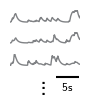

In [273]:
figsize_patterns = (2*cm, 2.5*cm)

fig = MultiPanel(grid=[1] * (4), figsize=figsize_patterns)

input_indices = [2, 6, 9]

for i in range(3):
    fig.panels[i].plot(inp_ts_chunk, x[:,input_indices[i]], color=color_inputs, lw=linewidth)
    fig.panels[i].set_ylim(-0.1*np.max(x[:,input_indices[i]]),np.max(x[:,input_indices[i]]))


for panel in fig.panels:
    panel.axis('off')
    panel.set_xlim(0, inp_ts_chunk.max())

add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=5.0, sizey=0.0,
    labelx='5s', labely='0.0',
    loc='lower right', barwidth=1.5, pad=0, sep=5)

# three vertical dots on last axis
fig.panels[-1].text(0.5, 0.5, r'$\vdots$', fontsize=20, color='black', ha='center', va='center',
                   transform=fig.panels[-1].transAxes)

plt.savefig(figure_directory / "2a_inputs.pdf", bbox_inches='tight')
plt.show()

#### Panel 3a: Stimulus pattern activity

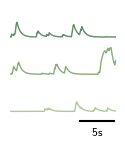

In [274]:
figsize_patterns = (2.9*cm, 3.5*cm)

fig = MultiPanel(grid=[1] * (Nb_patterns + 1), figsize=figsize_patterns,
                 height_ratios=[1,1,1,0.1])

for i in range(Nb_patterns):
    fig.panels[i].plot(inp_ts_chunk, p[:,i], color=colors_patterns[i], lw=linewidth)
    fig.panels[i].set_ylim(-0.5, 1*np.max(p))
    fig.panels[i].set_yticks([0, 10])

for i in range(Nb_patterns-1):
    fig.panels[i].set_xticklabels([])

#fig.fig.supylabel(r'Activity [a.u.]', fontsize=6)

for panel in fig.panels:
    panel.axis('off')
    panel.set_xlim(0, inp_ts_chunk.max())

add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=5.0, sizey=0.0,
    labelx='5s', labely='0.0',
    loc='lower right', barwidth=1.5, pad=0, sep=5)

plt.savefig(figure_directory / "3a_patterns.pdf", bbox_inches='tight')
plt.show()

#### Panel 3a: Input neuron activity

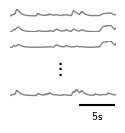

In [275]:
figsize_patterns = (2.9*cm, 3.1*cm)

fig = MultiPanel(grid=[1] * (6), figsize=figsize_patterns, height_ratios=[1,1,1,0.1,1,0.1])

for i in range(5):
    if i !=3:
        fig.panels[i].plot(inp_ts_chunk, x[:,i*2], color=color_inputs, lw=linewidth)
        fig.panels[i].set_ylim(-0.1*np.max(x[:,i*2]),np.max(x[:,i*2]))

# fourth axis plot three vertical dots indicating more inputs

fig.panels[3].text(0.5, 0.5, r'$\vdots$', fontsize=20, color='black', ha='center', va='center',
                   transform=fig.panels[3].transAxes)

for panel in fig.panels:
    panel.axis('off')
    panel.set_xlim(0, inp_ts_chunk.max())

add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=5.0, sizey=0.0,
    labelx='5s', labely='0.0',
    loc='lower right', barwidth=1.5, pad=0, sep=5)

plt.savefig(figure_directory / "3a_inputs.pdf", bbox_inches='tight')
plt.show()

## Illustration of precise E/I balance

In [276]:
# Advance RNG
seed+=1

# Run simulation
OL_results, CL_results, x, y = test(state, sim, inputs, 0, seed=jax.random.PRNGKey(seed), return_input=True)

# Print keys of result dictionary
print(OL_results.keys())

dict_keys(['B', 'I_FF_bar', 'W_FF', 'W_OUT', 'eligR', 'eligX', 'eligX2', 'uE', 'uI', 'uOut', 'rE', 'rI', 'ctrl', 'fb', 'I_XE', 'I_IE', 'error_hidden', 'Loss', 'R2'])


In [277]:
# Take one example neuron from the assembly
ex_neuron_idx = 2

# Split FF weights into positive and negative parts
W_FF_pos = state['W_FF'].clip(0) 
W_FF_neg = (-state['W_FF']).clip(0)

# Get exc & type1 inh (ff inh) currents
I_exc = jnp.dot(x, W_FF_pos).squeeze() * vf.M_E[ex_neuron_idx, :].squeeze()
I_inh_1 = jnp.dot(x, W_FF_neg).squeeze() * vf.M_E[ex_neuron_idx, :].squeeze()

# Get type2 inh (feedback inh) currents
I_inh_2 = OL_results['I_IE'][:,ex_neuron_idx].squeeze()

# Total inhibitory current
I_inh = I_inh_1 + I_inh_2

#### Panel 2b: Synaptic currents

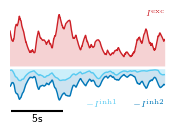

In [278]:
fig = MultiPanel(grid=[1,1], figsize=(4*cm, 3*cm), hspace=-1, wspace=-0.5, height_ratios=[1,1])

ax1 = fig.panels[0]
ax2 = fig.panels[1]

ax1.fill_between(inp_ts_chunk, 0, I_exc, color=color_exc, alpha=0.2, lw=0)
ax1.plot(inp_ts_chunk, I_exc, color=color_exc, lw=linewidth)

# Annotated 'I^\mathrm{exc}'
ax1.text(1, 1, r'$I^\mathrm{exc}$', fontsize=6, ha='right', va='top',
            transform=ax1.transAxes, color=color_exc)

# fill between inh_1 and inh_2 separately
ax2.fill_between(inp_ts_chunk, 0, -I_inh_1, color=color_inh_ff, alpha=0.3, lw=0)
ax2.plot(inp_ts_chunk, -I_inh_1, color=color_inh_ff, lw=linewidth)
ax2.fill_between(inp_ts_chunk, -I_inh_1, -I_inh, color=color_inh, alpha=0.2, lw=0)
ax2.plot(inp_ts_chunk, -I_inh, color=color_inh, lw=linewidth)

# Annotated 'I^\mathrm{inh}'
ax2.text(1, 0.3, r'$-I^\mathrm{inh2}$', fontsize=6, ha='right', va='bottom',
            transform=ax2.transAxes, color=color_inh)
ax2.text(0.7, 0.3, r'$-I^\mathrm{inh1}$', fontsize=6, ha='right', va='bottom',
            transform=ax2.transAxes, color=color_inh_ff)

for ax in fig.panels:
    ax.axis('off')
    ax.set_xlim(0.05, inp_ts_chunk.max())

# Y-axis
fig.panels[0].set_ylim(0, 1.1*np.max(I_exc))
fig.panels[1].set_ylim(-1.1*np.max(I_exc), 0)

# SCALEBAR ON SEPARATE AXIS

add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=5.0, sizey=0,
    labelx='5s',
    loc='lower left', barwidth=1.5, pad=0, sep=2)


# Padding
fig.fig.get_layout_engine().set(w_pad=1 / 72, h_pad=1 / 72, hspace=0,
                            wspace=0)

plt.savefig(figure_directory / "2b_synaptic_currents.pdf")
plt.show()

#### Panel not shown in paper: Filtered feed-forward currents & type 2 inhibition

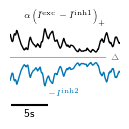

In [279]:
I_total = I_exc - I_inh
I_FF = alpha * OL_results['I_FF_bar'][:,ex_neuron_idx].squeeze()
I_IE = OL_results['I_IE'][:,ex_neuron_idx].squeeze()
Delta = I_FF - I_IE

fig = MultiPanel(grid=[1,1], figsize=(3*cm, 3*cm), hspace=-1, wspace=-0.5, height_ratios=[1,0.1])

ax1 = fig.panels[0]
ax2 = fig.panels[1]

ax1.plot(inp_ts_chunk, I_FF, color='black', lw=linewidth)

# Annotated 'I^\mathrm{exc}'
ax1.text(0.5, 1, r'$\alpha \left(\bar I^\mathrm{exc} - \bar I^\mathrm{inh1}\right)_+$', fontsize=6, ha='center', va='bottom',
            transform=ax1.transAxes, color='black')

# Inh 2
ax1.plot(inp_ts_chunk, -I_IE, color=color_inh, lw=linewidth)

# Annotated 'I^\mathrm{inh}'
ax1.text(0.5, 0, r'$-I^\mathrm{inh2}$', fontsize=6, ha='center', va='top',
            transform=ax1.transAxes, color=color_inh)

# Delta
ax1.plot(inp_ts_chunk, Delta, color='gray', lw=linewidth/2)

# Annotate Delta
ax1.text(1.0, 0.5, r'$\Delta$', fontsize=6, ha='right', va='center',
            transform=ax1.transAxes, color='gray', backgroundcolor='white')

for ax in fig.panels:
    ax.axis('off')
    ax.set_xlim(0.05, inp_ts_chunk.max())

# SCALEBAR ON SEPARATE AXIS
add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=5.0, sizey=0.0,
    labelx='5s', labely='0.0',
    loc='lower left', barwidth=1.5, pad=0, sep=2)

plt.savefig(figure_directory / "NA_precise-balance.pdf")
plt.show()

## Illustration of top-down control

In [280]:
# Advance RNG
seed+=1

# Run simulation
results = illustrate_top_down_control(state, sim, inputs, seed=seed)

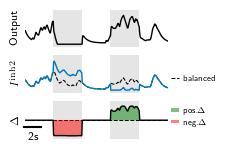

In [281]:
figsize_control_illus = (5.5*cm, 3.5*cm)

fig = MultiPanel(grid=[1, 1, 1], figsize=figsize_control_illus)

uE = results['uE'][:,ex_neuron_idx].squeeze()
rE = vf.actE(uE)
I_IE = results['I_IE'][:,ex_neuron_idx].squeeze()
I_FF_bar = results['I_FF_bar'][:,ex_neuron_idx].squeeze()

balance_target = vf.alpha * jax.nn.relu(I_FF_bar)
ERROR = balance_target - I_IE

chunk = int(rE.shape[0]/5)  # 5 chunks of 3s
chunk_t = chunk*input_dt

for p in fig.panels:
    #p.axis('off')
    p.set_xlim(0.1, inp_ts_chunk.max())
    
    # remove bottom spine, ticks and labels
    p.spines['bottom'].set_visible(False)
    p.set_xticks([])
    p.set_xticklabels([])
    p.set_yticks([])
    p.set_yticklabels([])
    p.spines['left'].set_visible(False)

# FIRING RATE
fig.panels[0].plot(inp_ts_chunk, rE.squeeze(), color='black', zorder=10)

# make shaded regions for the different feedbacks
fig.panels[0].axvspan(chunk_t, chunk_t*2, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)
fig.panels[0].axvspan(chunk_t*3, chunk_t*4, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)

fig.panels[0].set_ylim(-0.1*np.max(rE), 1.2*np.max(rE))
fig.panels[0].set_ylabel(r'Output')

# CURRENT
fig.panels[1].plot(inp_ts_chunk, balance_target, color='black', lw=linewidth*0.75, 
                   label='balanced', ls='dashed', zorder=1)
fig.panels[1].plot(inp_ts_chunk, I_IE, color=color_inh, lw=linewidth, zorder=10)

fig.panels[1].axvspan(chunk_t, chunk_t*2, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)
fig.panels[1].axvspan(chunk_t*3, chunk_t*4, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)

fig.panels[1].legend(loc=(1, 0.2), fontsize=6, handlelength=1, handletextpad=0.4)
fig.panels[1].set_ylabel(r'$I^\mathrm{inh2}$')
fig.panels[1].set_ylim(-0.1*np.max(I_IE), 1.2*np.max(I_IE))

# ERROR
fig.panels[2].plot(inp_ts_chunk, ERROR, color='black', lw=linewidth, zorder=10)
fig.panels[2].axhline(0, color='black', lw=linewidth*0.75, ls='dashed', zorder=1)

# Fill green where error is positive, red where error is negative
fig.panels[2].fill_between(inp_ts_chunk, 0, ERROR.squeeze(), where=ERROR.squeeze() > 0, color='green', alpha=0.5, zorder=1,
                           label=r'pos.$\Delta$', linewidth=0.0)
fig.panels[2].fill_between(inp_ts_chunk, 0, ERROR.squeeze(), where=ERROR.squeeze() < 0, color='red', alpha=0.5, zorder=1,
                            label=r'neg.$\Delta$', linewidth=0.0)

fig.panels[2].axvspan(chunk_t, chunk_t*2, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)
fig.panels[2].axvspan(chunk_t*3, chunk_t*4, color=color_shading, alpha=0.2, zorder=0, linewidth=0.0)

fig.panels[2].legend(loc=(1, 0.25), fontsize=6, 
                     handleheight=0.25, handlelength=1, handletextpad=0.4)

fig.panels[2].set_ylim(-1.2*np.max(np.abs(ERROR)), 1.2*np.max(np.abs(ERROR)))
fig.panels[2].set_ylabel(r'$\Delta$')

add_scalebar(fig.panels[-1], matchx=False, matchy=False,
    sizex=2.0, sizey=0.0,
    labelx='2s', labely='0.0',
    loc=('lower left'), barwidth=1.5, pad=-0.3, sep=3, hidey=False)


plt.savefig(figure_directory / "2d_feedback.pdf", bbox_inches='tight')
plt.show()

## Stimulus-selectivity task (Figure 3)

#### Record Selectivity before training

In [282]:
# Record Selectivity (t0)
OLRFs, CLRFs = test_RFs(inputs, 0, state, sim)

#### Training setup

In [283]:
ep_noFB = 160
ep_train = 160
nb_epochs = ep_noFB * 2 + ep_train * 2
T_all = nb_epochs * T_chunk

rec_ep_step = 4
epochs_rec_Xaxis = jnp.arange(0, nb_epochs, rec_ep_step)
T_rec_Xaxis = epochs_rec_Xaxis * T_chunk / 60


def epoch_noFB(state, sim, inputs, seed, rec_result=False):
    
    x, y = get_x_and_y(inputs, 0, seed)
    x_interp, y_interp = interpolate(x, y)
    
    state, sol = sim.learn_OL(state, x_interp, y_interp)
    
    if rec_result:
        result = sim.vectorfield.analyze_run(x, sol, dt, rec_dt, y, closedloop=False)
        return state, sol, result
    
    return state, sol

def epoch_FB(state, sim, inputs, y_idx, seed, rec_result=False):
    
    x, y = get_x_and_y(inputs, y_idx, seed)
    x_interp, y_interp = interpolate(x, y)
    
    state, sol = sim.learn(state, x_interp, y_interp)
    
    if rec_result:
        result = sim.vectorfield.analyze_run(x, sol, dt, rec_dt, y, closedloop=True)
        return state, sol, result
    
    return state, sol


#### Training phase

In [284]:
W_FF_rec = []
W_OUT_rec = []
FB_rec = []

# BURN-IN 
# # # # # # # # # 

print("Burn-in")
for epoch in range(int(ep_noFB/2)):
    seed+=1

    if epoch % rec_ep_step == 0:
        state, sol, res = epoch_noFB(state, sim, inputs, seed, rec_result=True)

        W_FF_rec.append(state['W_FF'])
        W_OUT_rec.append(state['W_OUT'])
        FB_rec.append(np.abs(res['fb']).mean())        
    else:
        state, sol = epoch_noFB(state, sim, inputs, seed)



# TRAINING 1
# # # # # # # # #

print("Training 1")
for epoch in range(ep_train):
    seed+=1

    if epoch % rec_ep_step == 0:
        state, sol, res = epoch_FB(state, sim, inputs, 0, seed, rec_result=True)

        W_FF_rec.append(state['W_FF'])
        W_OUT_rec.append(state['W_OUT'])
        FB_rec.append(np.abs(res['fb']).mean())        
        
    else:
        state, sol = epoch_FB(state, sim, inputs, 0, seed)

# PAUSE
# # # # # # # # #

print("Pause")
for epoch in range(ep_noFB):
    seed+=1

    if epoch % rec_ep_step == 0:
        state, sol, res = epoch_noFB(state, sim, inputs, seed, rec_result=True)

        W_FF_rec.append(state['W_FF'])
        W_OUT_rec.append(state['W_OUT'])
        FB_rec.append(np.abs(res['fb']).mean())        
        
    else:
        state, sol = epoch_noFB(state, sim, inputs, seed)

# Record Selectivity (t1)
OLRFs2, CLRFs2 = test_RFs(inputs, 0, state, sim)

# TRAINING 2
# # # # # # # # #

print("Training 2")
for epoch in range(ep_train):
    seed+=1

    if epoch % rec_ep_step == 0:
        state, sol, res = epoch_FB(state, sim, inputs, 1, seed, rec_result=True)

        W_FF_rec.append(state['W_FF'])
        W_OUT_rec.append(state['W_OUT'])
        FB_rec.append(np.abs(res['fb']).mean())        
        
    else:
        state, sol = epoch_FB(state, sim, inputs, 1, seed)

# PAUSE
# # # # # # # # #

print("Pause")
for epoch in range(int(ep_noFB/2)):
    seed+=1

    if epoch % rec_ep_step == 0:
        state, sol, res = epoch_noFB(state, sim, inputs, seed, rec_result=True)

        W_FF_rec.append(state['W_FF'])
        W_OUT_rec.append(state['W_OUT'])
        FB_rec.append(np.abs(res['fb']).mean())        
        
    else:
        state, sol = epoch_noFB(state, sim, inputs, seed)



Burn-in
Training 1
Pause
Training 2
Pause


#### Process recording arrays

In [285]:
W_FF_rec = np.stack(W_FF_rec)[:,:,0]
W_OUT_rec = np.stack(W_OUT_rec)
W_FF_patterns = np.dot(W_FF_rec, inputs.W.T)
FB_rec = np.stack(FB_rec).squeeze()

#### Panel 3c: FF vs Type 2 Inh. currents at different time points

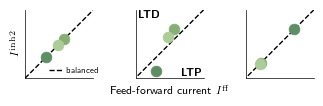

In [286]:
fig = MultiPanel(grid=[3], figsize=(8.4*cm, 2.4*cm))

for p in range(Nb_patterns):
    
    # t0
    fig.panels[0].scatter(vf.alpha * OLRFs[p]['I_FF_bar'][ex_neuron_idx], 
                          OLRFs[p]['I_IE'][ex_neuron_idx], 
                          color=colors_patterns[p],
                          s = 60)
    
    # Annotate patterns with letter (A,B,C...) above the points
    #fig.panels[0].annotate(chr(65+p), (OLRFs[p]['I_FF_tilde'], OLRFs[p]['I_IE'] + 0.1), 
    #                       fontsize=10, ha='center', va='bottom', color=colors_patterns[p], fontweight='bold')


    # t1
    fig.panels[1].scatter(vf.alpha * CLRFs[p]['I_FF_bar'][ex_neuron_idx], 
                          CLRFs[p]['I_IE'][ex_neuron_idx], 
                          color=colors_patterns[p],
                          s = 60)
    
    # annotate
    #fig.panels[1].annotate(chr(65+p), (CLRFs[p]['I_FF_tilde'], CLRFs[p]['I_IE'] + 0.1), 
    #                       fontsize=10, ha='center', va='bottom', color=colors_patterns[p], fontweight='bold')

    #t2
    fig.panels[2].scatter(vf.alpha * OLRFs2[p]['I_FF_bar'][ex_neuron_idx], 
                          OLRFs2[p]['I_IE'][ex_neuron_idx], 
                          color=colors_patterns[p],
                          s = 60)
    

# plot line resembling y = alpha * x
fig.panels[0].plot([-1, 5], 
                   [-1, 5], 
                   color='black', linestyle='--', lw=1, zorder=-10, label='balanced')

fig.panels[1].plot([-1, 5],
                   [-1, 5],
                   color='black', linestyle='--', lw=1, zorder=-10, label='balanced')


fig.panels[2].plot([-1, 5],
                   [-1, 5],
                   color='black', linestyle='--', lw=1, zorder=-10, label='balanced')

axmin = -0.02
axmax = 0.18

fig.panels[0].set_xlim(axmin, axmax)
fig.panels[0].set_ylim(axmin, axmax)

fig.panels[1].set_xlim(axmin, axmax)
fig.panels[1].set_ylim(axmin, axmax)

fig.panels[2].set_xlim(axmin, axmax)
fig.panels[2].set_ylim(axmin, axmax)

fig.panels[0].set_yticks([])
fig.panels[0].set_xticks([])
fig.panels[1].set_yticks([])
fig.panels[1].set_xticks([])
fig.panels[2].set_yticks([])
fig.panels[2].set_xticks([])


fig.fig.supxlabel(r'Feed-forward current $I^{\mathrm{ff}}$', fontsize=8)
fig.panels[0].set_ylabel(r'$I^{\mathrm{inh2}}$', fontsize=8)
fig.panels[0].legend(handlelength=1.5, handletextpad=0.5, fontsize=6, loc=(0.3, 0.0))

#fig.panels[0].set_title('No Feedback', fontsize=8, fontweight='bold')
#fig.panels[1].set_title('\nPattern A relevant', fontsize=8, fontweight='bold')

# Equal aspect ratio
fig.panels[0].set_aspect('equal')
fig.panels[1].set_aspect('equal')
fig.panels[2].set_aspect('equal')

# Annotate 'LTP' in bottom right corner
fig.panels[1].text(1, 0, r'\textbf{LTP}', fontsize=8, ha='right', va='bottom', transform=fig.panels[1].transAxes)
fig.panels[1].text(0.05, 1, r'\textbf{LTD}', fontsize=8, ha='left', va='top', transform=fig.panels[1].transAxes)

plt.savefig(figure_directory / "3c_balanced_currents.pdf", bbox_inches='tight')
plt.show()

#### Panel 3d: Weights & Feedback over time

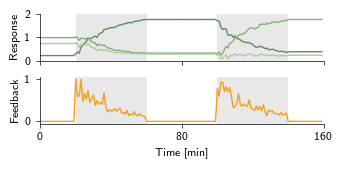

In [287]:
figsize_weights_fb_over_time = (8.4*cm, 4*cm)

fig = MultiPanel(grid=[1, 1], figsize=figsize_weights_fb_over_time)

# PANEL 1: Weights
ax = fig.panels[0]

# Shaded region for training periods
start1 = ep_noFB/2 * T_chunk / 60
end1 = (ep_noFB/2 + ep_train) * T_chunk / 60
start2 = (ep_noFB * 1.5 + ep_train) * T_chunk / 60
end2 = (ep_noFB * 1.5 + 2 * ep_train) * T_chunk / 60

ax.axvspan(start1, end1, color='lightgray', alpha=0.5, zorder=-1, linewidth=0.0)
ax.axvspan(start2, end2, color='lightgray', alpha=0.5, zorder=-1, linewidth=0.0)
#ax.text((start1 + end1) / 2, 2.5, 'A', fontsize=10, color=colors_patterns[0], ha='center', fontweight='bold')
#ax.text((start2 + end2) / 2, 2.5, 'B', fontsize=10, color=colors_patterns[1], ha='center', fontweight='bold')

for pattern in range(Nb_patterns):
    ax.plot(T_rec_Xaxis, W_FF_patterns[:, pattern], color=colors_patterns[pattern], lw=linewidth)

ax.set_ylabel(r'Response')
#ax.set_ylim(-1.2, 1.2)
ax.set_ylim(0, 2)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])
ax.set_xticklabels([])
ax.set_xlim(0, T_all / 60)
ax.set_xticks([0, T_all / 60 / 2, T_all / 60])

# PANEL 2: FB
ax = fig.panels[1]

abs_FB = jnp.abs(FB_rec) / np.max(jnp.abs(FB_rec))

ax.plot(abs_FB, color=color_closedloop, lw=linewidth)
ax.axvspan(start1, end1, color='lightgray', alpha=0.5, zorder=-1, linewidth=0.0)
ax.axvspan(start2, end2, color='lightgray', alpha=0.5, zorder=-1, linewidth=0.0)
#ax.text((start1 + end1) / 2, 2.5, 'A', fontsize=10, color=colors_patterns[0], ha='center', fontweight='bold')
#ax.text((start2 + end2) / 2, 2.5, 'B', fontsize=10, color=colors_patterns[1], ha='center', fontweight='bold')


ax.set_ylabel(r'Feedback')
ax.set_xlabel(r'Time [min]', fontsize=8)
ax.set_xlim(0, T_all / 60)
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.set_xticks([0, T_all / 60 / 2, T_all / 60])
ax.set_xticklabels([0, int(T_all / 60 / 2), int(T_all / 60)])

plt.savefig(figure_directory / "3d_weights_fb_over_time.pdf", bbox_inches='tight')
plt.show()

#### Panel 2g: Illustration of the BCP learning rule in the absence of E -> I recurrence

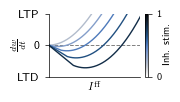

In [288]:
def dw_simple(x, alpha, I_exc, I_inh):
    return x * (alpha * I_exc - I_inh)

def relu(x):
    return jnp.maximum(0, x)

I_exc = np.arange(0, 4, 0.01)

# make 5 lines with different inh
inhs = [0.0, 0.2, 0.4, 0.6, 0.8]

# colors from cmap
cmap = cmc.cmaps['oslo_r']
colors = cmap(np.linspace(0.2, 0.8, len(inhs)))

fig, ax = plt.subplots(1, 1, figsize=(4.3*cm, 2.3*cm))

for i, inh in enumerate(inhs):
    r = relu(I_exc - inh)
    ax.plot(I_exc, dw_simple(I_exc, 0.5, r, inh), color=colors[i], lw=linewidth)

ax.set_xlabel(r'$I^{\mathrm{ff}}$')
ax.set_ylabel(r'$\frac{dw}{dt}$', fontsize=8, labelpad=-5)

ax.set_ylim(-1, 1)
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(['LTD', 0, 'LTP'])
ax.set_xlim(0, 3)
ax.set_xticks([])
ax.set_xticklabels([])

ax.hlines(0, 0, 3, color='gray', lw=linewidth*0.7, ls='dashed', zorder=-1)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_ticks([0, 1])
cbar.set_label(r'Inh. stim.', fontsize=7, labelpad=0)
cbar.set_ticklabels(['0', '1'], fontsize=7)

plt.savefig(figure_directory / "2g_dw_simple.pdf", bbox_inches='tight')
plt.show()